### Ref

In [2]:
# https://yungyung7654321.medium.com/python%E5%AF%A6%E4%BD%9C%E8%87%AA%E5%8B%95%E5%85%A8%E6%99%AF%E5%9C%96%E6%8B%BC%E6%8E%A5-automatic-panoramic-image-stitching-28629c912b5a
# https://github.com/dastratakos/Homography-Estimation/blob/main/imageAnalysis.py
# https://zhuanlan.zhihu.com/p/34761031
# https://github.com/j40903272/VFX2018
# https://www.analyticsvidhya.com/blog/2021/06/feature-detection-description-and-matching-of-images-using-opencv/
# https://github.com/jnfem112/VFX2022SPRING
# https://www.geekering.com/programming-languages/python/brunorsilva/harris-corner-detector-python/

### Environment Setup

In [3]:
from pylab import *
import numpy as np
from scipy.ndimage.filters import maximum_filter
import scipy
from matplotlib import pyplot as plt
import cv2
import random
%matplotlib inline

C:\Users\yuting\AppData\Local\Temp\ipykernel_3436\1505477649.py:3: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter


## Harris Corner Detection

### Color to grayscale

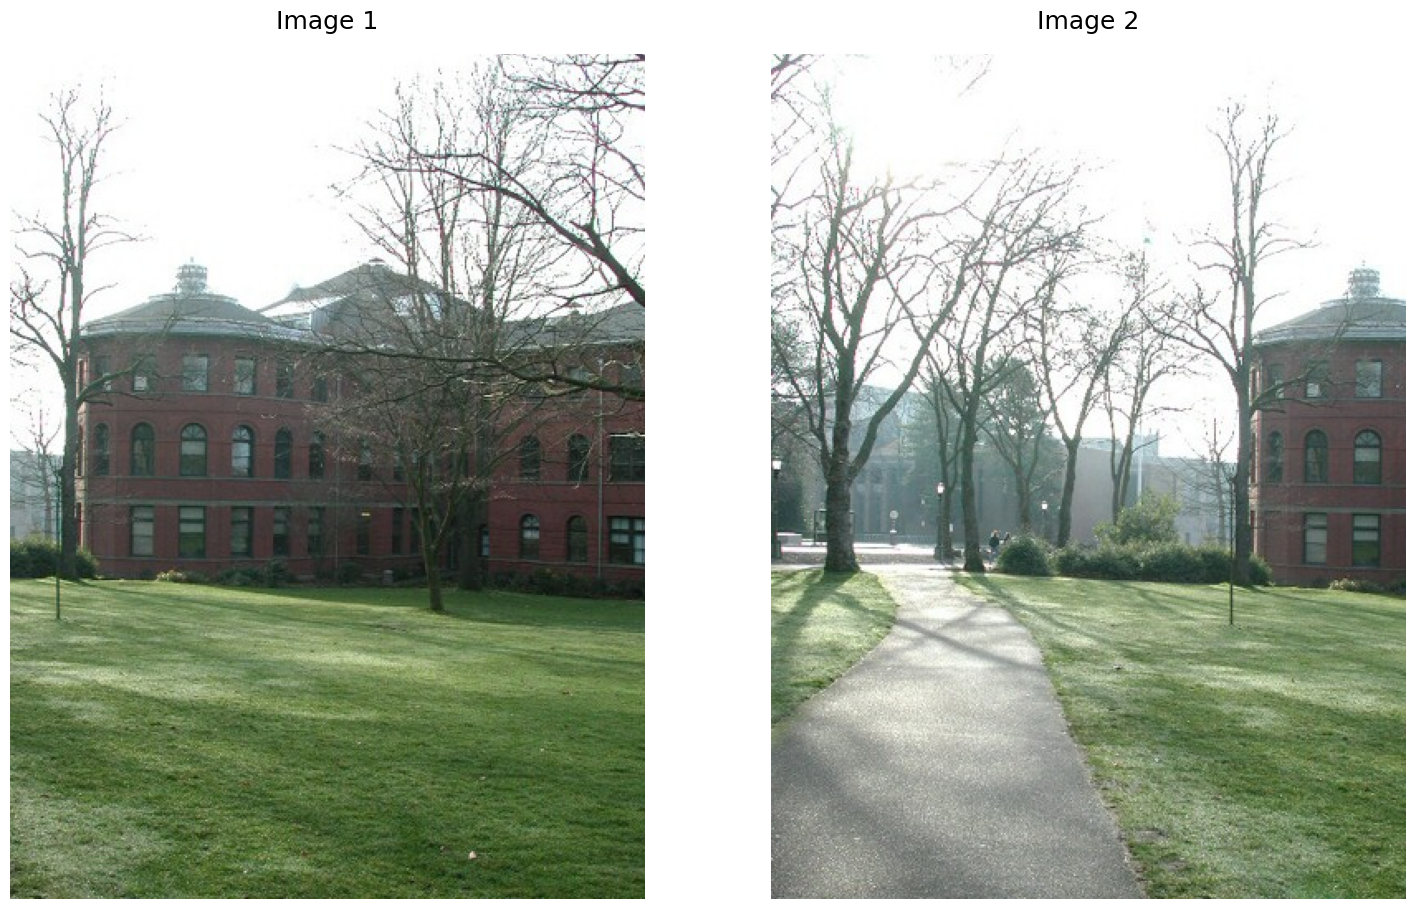

In [4]:
img1 = cv2.imread('../data/prtn00.jpg')
gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('../data/prtn01.jpg')
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

fig , axes = plt.subplots(1 , 2 , figsize = (18 , 32))
ax = axes[0]
ax.set_title(f'Image 1' , fontsize = 18 , y = 1.02)
ax.imshow(cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = axes[1]
ax.set_title(f'Image 2' , fontsize = 18 , y = 1.02)
ax.imshow(cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB))
ax.set_axis_off()

## Harris response calculation

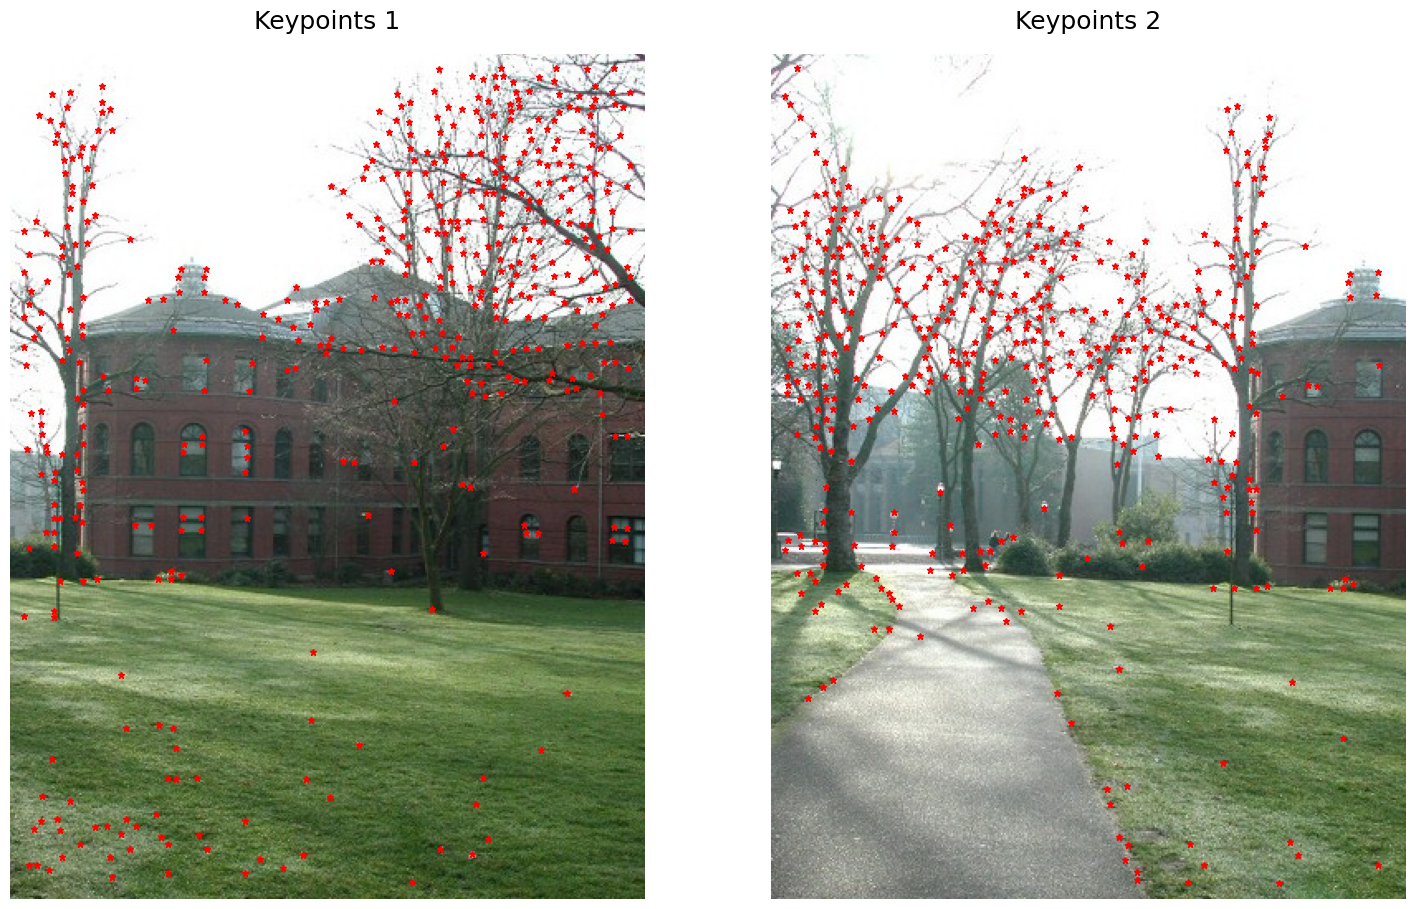

In [5]:
def harrisCornerDetector(img, k=0.05):
    
    # denoise
    blur_img = cv2.GaussianBlur(img, (3,3), 0)
    
    # derivatives
    # dy, dx = np.gradient(gray)
    Ix = cv2.Sobel(blur_img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(blur_img, cv2.CV_64F, 0, 1, ksize=3)
    
    # compute components of the Harris matrix
    Ixx = Ix*Ix
    Ixy = Ix*Iy
    Iyy = Iy*Iy
    
    # sum with gaussian window
    Sxx = cv2.GaussianBlur(Ixx, (3,3), 0)
    Sxy = cv2.GaussianBlur(Ixy, (3,3), 0)
    Syy = cv2.GaussianBlur(Iyy, (3,3), 0)
    
    # compute R 
    det = Sxx*Syy - Sxy*Sxy
    trace = Sxx + Syy
    R = det - k*(trace**2)
    
    return R

def non_maximum_suppression(R, windows=8):
    h, w = R.shape[0:2]
    
    R[:windows, :] = 0
    R[-windows:, :] = 0
    R[:, -windows:] = 0
    R[:, :windows] = 0

    # non-maximum suppression in winxwin regions
    local_maximum = maximum_filter(R, (windows, windows))
    R[R!=local_maximum] = 0
    
    return R

def get_top_N_keypoints(R, N=512):
    # https://stackoverflow.com/questions/29800393/how-to-get-the-index-of-the-largest-n-values-in-a-multi-dimensional-numpy-array
    # Find the indices in the 1D array
    # Convert it into a 1D array
    R_1d = R.flatten()

    # Find the indices in the 1D array
    idx_1d = R_1d.argsort()[-N:]

    # convert the idx_1d back into indices arrays for each dimension
    r_idx, c_idx = np.unravel_index(idx_1d, R.shape)

    # Check that we got the largest values.
    # for x, y, in zip(x_idx, y_idx):
    #     print(R[x][y])
    
    # concatenate positions and values
    keypoints = np.vstack((c_idx, r_idx)).T
    return keypoints
    
def get_keypoints(gray, windows=8, N=512):
    R = harrisCornerDetector(gray)
    R = non_maximum_suppression(R, windows)
    return get_top_N_keypoints(R, N)

  
keypoints1 = get_keypoints(gray1)
keypoints2 = get_keypoints(gray2)

fig , axes = plt.subplots(1 , 2 , figsize = (18 , 32))
ax = axes[0]
ax.set_title(f'Keypoints 1' , fontsize = 18 , y = 1.02)
ax.imshow(cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB))
ax.plot(keypoints1[:, 0], keypoints1[:, 1], 'r*', markersize=5)
ax.set_axis_off()

ax = axes[1]
ax.set_title(f'Keypoints 2' , fontsize = 18 , y = 1.02)
ax.imshow(cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB))
ax.plot(keypoints2[:, 0], keypoints2[:, 1], 'r*', markersize=5)
ax.set_axis_off()

In [6]:
def gen_descriptors(img, keypoints, windows=8): #return pixel value
    windows//=2
    descriptors = []
    for keypoint in keypoints: 
        x, y = int(keypoint[0]), int(keypoint[1]) #x水平方向 y垂直方向
        patch = img[y-windows:y+windows+1, x-windows:x+windows+1]
        patch = (patch - patch.mean()) / patch.std() # 重要!
        descriptors.append(patch.flatten())
        
    return np.array(descriptors)

descriptors1 = gen_descriptors(gray1, keypoints1)
descriptors2 = gen_descriptors(gray2, keypoints2)
print(descriptors1.shape, descriptors2.shape)

(512, 81) (512, 81)


In [7]:
def match(d1, d2):
    n = len(d1)
    
    print(d1.shape, d2.shape)
    # 計算兩兩vector的距離，dists[0,1]代表d1[0]與d2[1]的距離
    dists = scipy.spatial.distance.cdist(d1, d2)
    # print ('dists', dists)
    
    # 對每個row由小到大做排序
    sort_idx = np.argsort(dists, 1)
    
    # 取第0個，代表取與每個d1距離最小的d2 idx
    best_idx = sort_idx[:, 0]
    
    # 取與每個d1距離最小的d2的dist
    best_dists = dists[range(n), best_idx]

    # 取距離第2小的dist
    second_best_idx = sort_idx[:, 1]
    second_best_dists = dists[range(n), second_best_idx]

    # 確認最小的dist足夠具有辨識度(best_dists/second_best_dists.mean() < 0.5)
    is_match = best_dists/second_best_dists.mean() < 0.5

    # 找出具有辨識度的desc idx (best_dist/second_best_dist < 0.5)
    desc_idx1 = np.where(is_match)[0]
    desc_idx2 = best_idx[desc_idx1]
    # print(desc_idx1.shape, desc_idx2.shape)
    
    # 將match到的idx存入match
    matches = np.array([desc_idx1, desc_idx2]).T
    
    return matches.astype(int)

# match(descriptors1, descriptors2) 


In [8]:
def appendimages(im1, im2): #the appended images displayed side by side for image mapping
    
    # select the image with the fewest rows and fill in enough empty rows
    row1 = im1.shape[0]
    row2 = im2.shape[0]
    
    if row1 < row2:
        im1 = np.concatenate((im1, np.zeros((row2-row1,im1.shape[1]))),axis=1)
    elif row1 > row2:
        im2 = np.concatenate((im2, np.zeros((row1-row2,im2.shape[1]))),axis=1)
    
    return np.concatenate((im1, im2), axis=1)

(512, 81) (512, 81)
24 matches


C:\Users\yuting\AppData\Local\Temp\ipykernel_3436\3936911232.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "c" (-> color=(0.0, 0.75, 0.75, 1)). The keyword argument will take precedence.
  plt.plot([p1[0], p2[0]+offset], [p1[1], p2[1]], 'c', c=[np.random.random(), np.random.random(), np.random.random()])


(-0.5, 767.5, 511.5, -0.5)

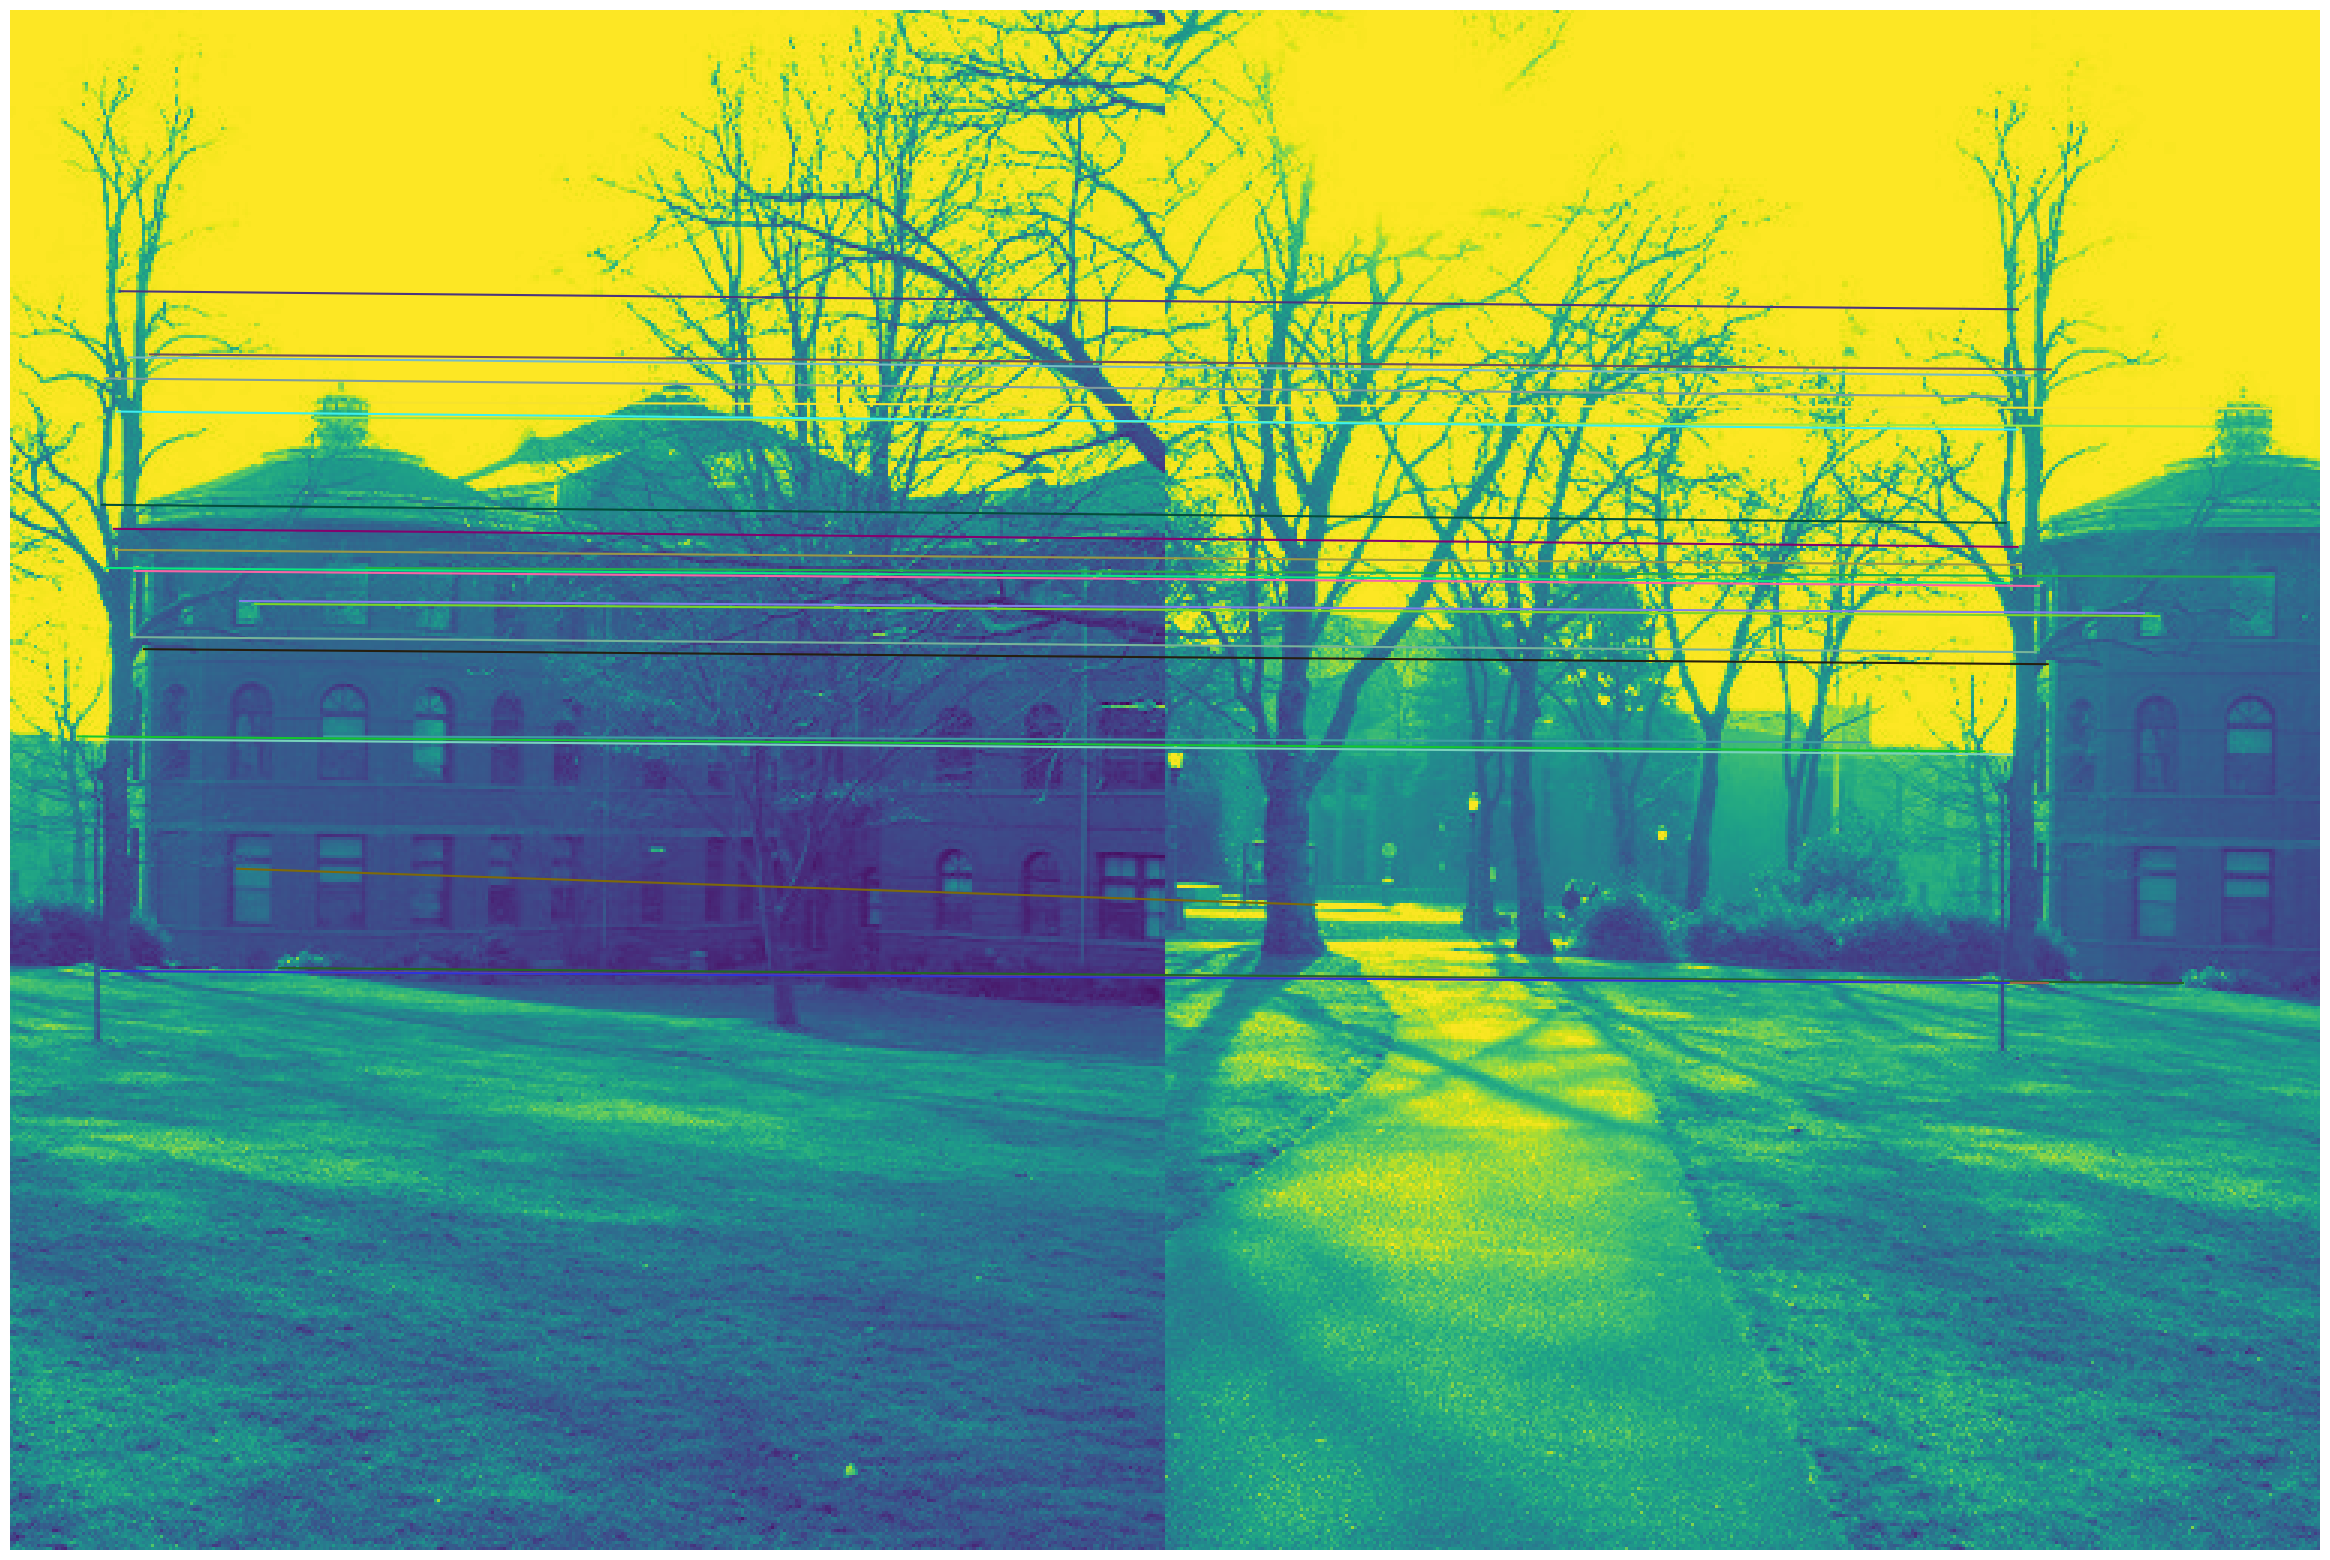

In [9]:
matches = match(descriptors1, descriptors2)
#matches = match2(descriptors, descriptors2, method='ed')
print (len(matches), 'matches')
im3 = appendimages(gray1,gray2)
#im3 = np.hstack((im3,im3))
plt.figure(figsize=(30, 20))
plt.imshow(im3)
offset = gray1.shape[1]
for i, m in enumerate(matches):
    p1, p2 = keypoints1[m[0]], keypoints2[m[1]]
    # [c1, c2], [r1, r2]
    plt.plot([p1[0], p2[0]+offset], [p1[1], p2[1]], 'c', c=[np.random.random(), np.random.random(), np.random.random()])
plt.axis('off')

### Homography 與 RANSAC

In [10]:
# 將matches轉成[x1, y1, x2, y2]
matches = [np.array([keypoints1[idx1], keypoints2[idx2]]).flatten() for idx1, idx2 in matches]
matches = np.array(matches)

In [11]:
def compute_homography(points):
    # 計算transform矩陣
    A = []
    for x1, y1, x2, y2 in points:
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
    A = np.array(A)

    # Singular Value Decomposition (SVD)
    U, S, V = np.linalg.svd(A)

    # V has shape (9, 9) for any number of input pairs. V[-1] is the eigenvector
    # of (A^T)A with the smalles eigenvalue. Reshape into 3x3 matrix.
    H = np.reshape(V[-1], (3, 3))

    # Normalization
    H = (1 / H.item(8)) * H
    return H

def random_point_pairs(matches, k=4):
    # 隨機取至少4個點
    idxs = random.sample(range(len(matches)), k)
    return matches[idxs]

def get_error(points, H):
    # 計算預估點與實際點的誤差
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])
        estimate_p2[i] = (temp/temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2

    return errors
def ransac(matches, threshold, iters):
    num_best_inliers = 0
    
    for i in range(iters):
        point_pair = random_point_pairs(matches, k=4)
        H = compute_homography(point_pair)
        
        #  avoid dividing by zero 
        if np.linalg.matrix_rank(H) < 3:
            continue
            
        errors = get_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()
            
    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers, best_H

inliers, H = ransac(matches, 0.5, 2000)

inliers/matches: 18/24


In [12]:
H

array([[ 9.12780621e-01, -1.39557938e-04,  2.46825746e+02],
       [-6.65590691e-02,  9.63253942e-01,  1.07593600e+01],
       [-2.18233246e-04, -5.89805821e-05,  1.00000000e+00]])

In [20]:
class Blender:
    def linearBlending(self, imgs):
        '''
        linear Blending(also known as Feathering)
        '''
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        img_left_mask = np.zeros((hr, wr), dtype="int")
        img_right_mask = np.zeros((hr, wr), dtype="int")
        
        # find the left image and right image mask region(Those not zero pixels)
        for i in range(hl):
            for j in range(wl):
                if np.count_nonzero(img_left[i, j]) > 0:
                    img_left_mask[i, j] = 1
        for i in range(hr):
            for j in range(wr):
                if np.count_nonzero(img_right[i, j]) > 0:
                    img_right_mask[i, j] = 1
        
        # find the overlap mask(overlap region of two image)
        overlap_mask = np.zeros((hr, wr), dtype="int")
        for i in range(hr):
            for j in range(wr):
                if (np.count_nonzero(img_left_mask[i, j]) > 0 and np.count_nonzero(img_right_mask[i, j]) > 0):
                    overlap_mask[i, j] = 1
        
        # Plot the overlap mask
        plt.figure(21)
        plt.title("overlap_mask")
        plt.imshow(overlap_mask.astype(int), cmap="gray")
        
        # compute the alpha mask to linear blending the overlap region
        alpha_mask = np.zeros((hr, wr)) # alpha value depend on left image
        for i in range(hr): 
            minIdx = maxIdx = -1
            for j in range(wr):
                if (overlap_mask[i, j] == 1 and minIdx == -1):
                    minIdx = j
                if (overlap_mask[i, j] == 1):
                    maxIdx = j
            
            if (minIdx == maxIdx): # represent this row's pixels are all zero, or only one pixel not zero
                continue
                
            decrease_step = 1 / (maxIdx - minIdx)
            for j in range(minIdx, maxIdx + 1):
                alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))
        
        
        
        linearBlending_img = np.copy(img_right)
        linearBlending_img[:hl, :wl] = np.copy(img_left)
        # linear blending
        for i in range(hr):
            for j in range(wr):
                if ( np.count_nonzero(overlap_mask[i, j]) > 0):
                    linearBlending_img[i, j] = alpha_mask[i, j] * img_left[i, j] + (1 - alpha_mask[i, j]) * img_right[i, j]
        
        return linearBlending_img
    def linearBlendingWithConstantWidth(self, imgs):
        '''
        linear Blending with Constat Width, avoiding ghost region
        # you need to determine the size of constant with
        '''
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        img_left_mask = np.zeros((hr, wr), dtype="int")
        img_right_mask = np.zeros((hr, wr), dtype="int")
        constant_width = 3 # constant width
        
        # find the left image and right image mask region(Those not zero pixels)
        for i in range(hl):
            for j in range(wl):
                if np.count_nonzero(img_left[i, j]) > 0:
                    img_left_mask[i, j] = 1
        for i in range(hr):
            for j in range(wr):
                if np.count_nonzero(img_right[i, j]) > 0:
                    img_right_mask[i, j] = 1
                    
        # find the overlap mask(overlap region of two image)
        overlap_mask = np.zeros((hr, wr), dtype="int")
        for i in range(hr):
            for j in range(wr):
                if (np.count_nonzero(img_left_mask[i, j]) > 0 and np.count_nonzero(img_right_mask[i, j]) > 0):
                    overlap_mask[i, j] = 1
        
        # compute the alpha mask to linear blending the overlap region
        alpha_mask = np.zeros((hr, wr)) # alpha value depend on left image
        for i in range(hr):
            minIdx = maxIdx = -1
            for j in range(wr):
                if (overlap_mask[i, j] == 1 and minIdx == -1):
                    minIdx = j
                if (overlap_mask[i, j] == 1):
                    maxIdx = j
            
            if (minIdx == maxIdx): # represent this row's pixels are all zero, or only one pixel not zero
                continue
                
            decrease_step = 1 / (maxIdx - minIdx)
            
            # Find the middle line of overlapping regions, and only do linear blending to those regions very close to the middle line.
            middleIdx = int((maxIdx + minIdx) / 2)
            
            # left 
            for j in range(minIdx, middleIdx + 1):
                if (j >= middleIdx - constant_width):
                    alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))
                else:
                    alpha_mask[i, j] = 1
            # right
            for j in range(middleIdx + 1, maxIdx + 1):
                if (j <= middleIdx + constant_width):
                    alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))
                else:
                    alpha_mask[i, j] = 0

        
        linearBlendingWithConstantWidth_img = np.copy(img_right)
        linearBlendingWithConstantWidth_img[:hl, :wl] = np.copy(img_left)
        # linear blending with constant width
        for i in range(hr):
            for j in range(wr):
                if (np.count_nonzero(overlap_mask[i, j]) > 0):
                    linearBlendingWithConstantWidth_img[i, j] = alpha_mask[i, j] * img_left[i, j] + (1 - alpha_mask[i, j]) * img_right[i, j]
        
        return linearBlendingWithConstantWidth_img

In [23]:
def removeBlackBorder(img):
        '''
        Remove img's the black border 
        '''
        h, w = img.shape[:2]
        reduced_h, reduced_w = h, w
        # right to left
        for col in range(w - 1, -1, -1):
            all_black = True
            for i in range(h):
                if (np.count_nonzero(img[i, col]) > 0):
                    all_black = False
                    break
            if (all_black == True):
                reduced_w = reduced_w - 1
                
        # bottom to top 
        for row in range(h - 1, -1, -1):
            all_black = True
            for i in range(reduced_w):
                if (np.count_nonzero(img[row, i]) > 0):
                    all_black = False
                    break
            if (all_black == True):
                reduced_h = reduced_h - 1
        
        return img[:reduced_h, :reduced_w]

def warp(imgs, HomoMat, blending_mode):
        '''
           Warp image to create panoramic image
           There are three different blending method - noBlending、linearBlending、linearBlendingWithConstant
        '''
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        stitch_img = np.zeros( (max(hl, hr), wl + wr, 3), dtype="int") # create the (stitch)big image accroding the imgs height and width 
        
        if (blending_mode == "noBlending"):
            stitch_img[:hl, :wl] = img_left
            
        # Transform Right image(the coordination of right image) to destination iamge(the coordination of left image) with HomoMat
        inv_H = np.linalg.inv(HomoMat)
        for i in range(stitch_img.shape[0]):
            for j in range(stitch_img.shape[1]):
                coor = np.array([j, i, 1])
                img_right_coor = inv_H @ coor # the coordination of right image
                img_right_coor /= img_right_coor[2]
                
                # you can try like nearest neighbors or interpolation  
                y, x = int(round(img_right_coor[0])), int(round(img_right_coor[1])) # y for width, x for height
                
                
                # if the computed coordination not in the (hegiht, width) of right image, it's not need to be process 
                if (x < 0 or x >= hr or y < 0 or y >= wr):
                    continue
                # else we need the tranform for this pixel
                stitch_img[i, j] = img_right[x, y]
            
        
        # create the Blender object to blending the image
        blender = Blender()
        if (blending_mode == "linearBlending"):
            stitch_img = blender.linearBlending([img_left, stitch_img])
        elif (blending_mode == "linearBlendingWithConstant"):
            stitch_img = blender.linearBlendingWithConstantWidth([img_left, stitch_img])
        
        # remove the black border
        stitch_img = removeBlackBorder(stitch_img)
        
        return stitch_img

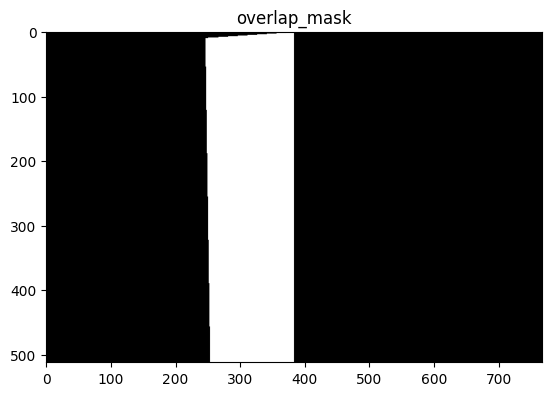

In [26]:
warp_img = warp([img2, img1], H, blending_mode = "linearBlending") 

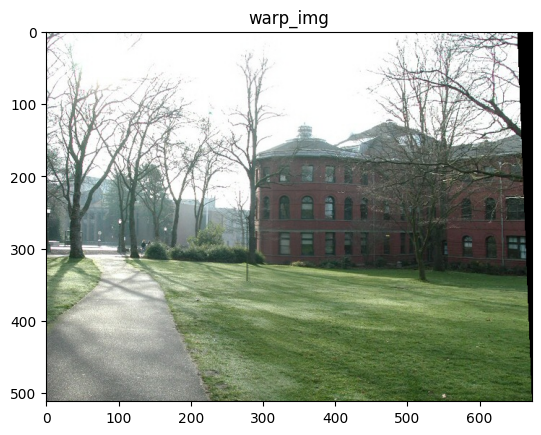

In [27]:
# plot the stitched image
plt.figure(13)
plt.title("warp_img")
plt.imshow(warp_img[:,:,::-1].astype(int))